## Exploratory Data Analysis

In [1]:
# Load the libraries
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



## Source
This data is from [UCI repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)

    Abstract: This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.

The dataset has 17839 instances and 16 attributes and no NA values, seperated in two csv files: `hour.csv` and `day.csv`. The following are list of attributes and their meanings:
 - instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

**Note**: The attribute `hr` is **not** included in `day.csv`

## Reading the data

In [2]:
# Reads the hourly data
#bike_sharing_hour <- read.csv("../data/hour.csv")
# Reads the daily data
bike_sharing_day <- read.csv("../data/day.csv")
#head(bike_sharing_hour)
head(bike_sharing_day)
nrow(bike_sharing_day)
#tail(bike_sharing_hour)
#head(bike_sharing_day)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.1604460,331,654,985
2,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.2485390,131,670,801
3,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.2483090,120,1229,1349
4,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.1602960,108,1454,1562
5,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.1869000,82,1518,1600
6,6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.0895652,88,1518,1606


[1] 731

In [3]:
colnames(bike_sharing_day)

[1] "instant"    "dteday"     "season"     "yr"         "mnth"      
 [6] "holiday"    "weekday"    "workingday" "weathersit" "temp"      
[11] "atemp"      "hum"        "windspeed"  "casual"     "registered"
[16] "cnt"

In [24]:
# Excluding some variables (irrevelant) <-- ADD explanation
# Consider adding other binary variables as well
total_dat <- bike_sharing_day %>%
             select(yr, temp, atemp, hum, windspeed, cnt)

# Train data 
train <- total_dat %>%
         slice(1:floor(0.75 * nrow(total_dat)))
# Test data
test <- total_dat %>%
        tail(n= nrow(total_dat) - nrow(train))



In [27]:
# Dummy model
mod <- lm(cnt ~ temp + atemp + hum + windspeed, data = train)
# Calculate rmse
rmse <- function(preds, actual){
    sqrt(mean(preds - actual)^2)
}

# Predictions are using model fitted with train to predict on test
# VS
# Actuals, the response variable column in the test data
rmse(preds = predict(mod, newdata = test), actual = test$cnt) 

[1] 1704.072

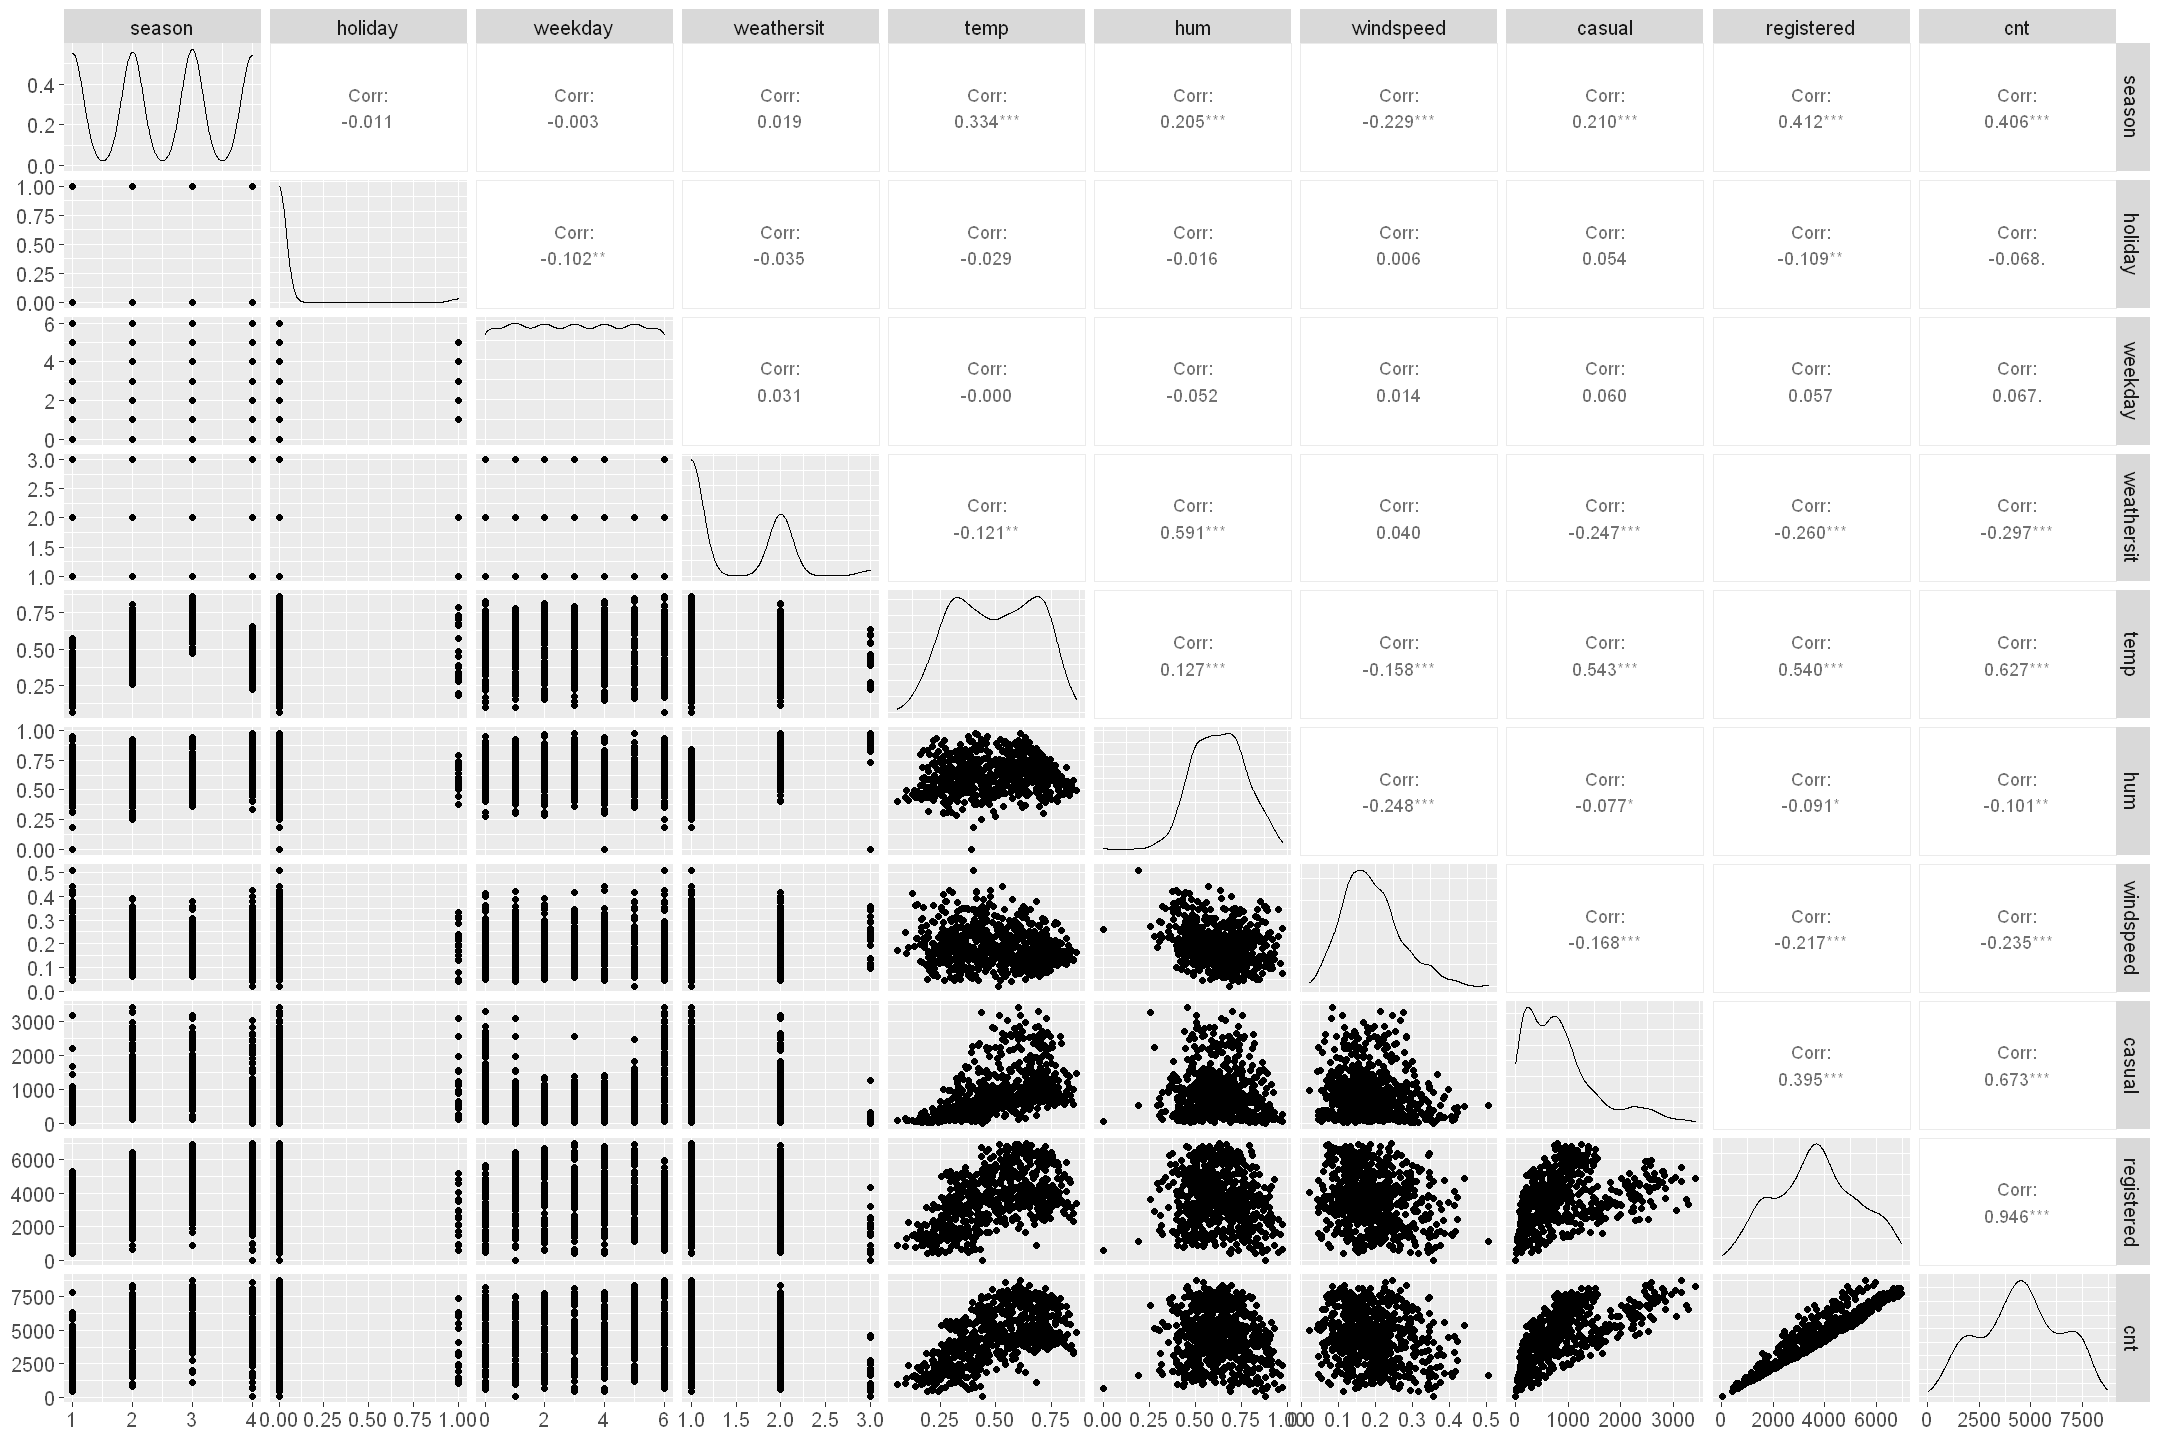

In [4]:
options(repr.plot.width = 18, repr.plot.height = 12)

bs_day_pair_plots <- bike_sharing_day %>%
  select(-c(atemp, mnth, yr, dteday, instant, workingday)) %>% 
  ggpairs(progress = FALSE) +
  theme(
    text = element_text(size = 15),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  )
bs_day_pair_plots

## Wrangling

In [65]:
# Wrangles the daily data to weekly and monthly
bike_sharing_wrangle <- bike_sharing_day %>%
                       select(-c(yr, mnth, holiday, weekday, workingday)) %>%
                       mutate(year = lubridate::year(dteday),
                              month = lubridate::month(dteday),
                              week = lubridate::week(dteday))
weekly <- bike_sharing_wrangle %>%
          group_by(year, week, season) %>%
          summarize(cnt = sum(cnt))

monthly <- bike_sharing_wrangle %>%
           group_by(year, month) %>%
           summarize(cnt = sum(cnt))


`summarise()` has grouped output by 'year', 'week'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


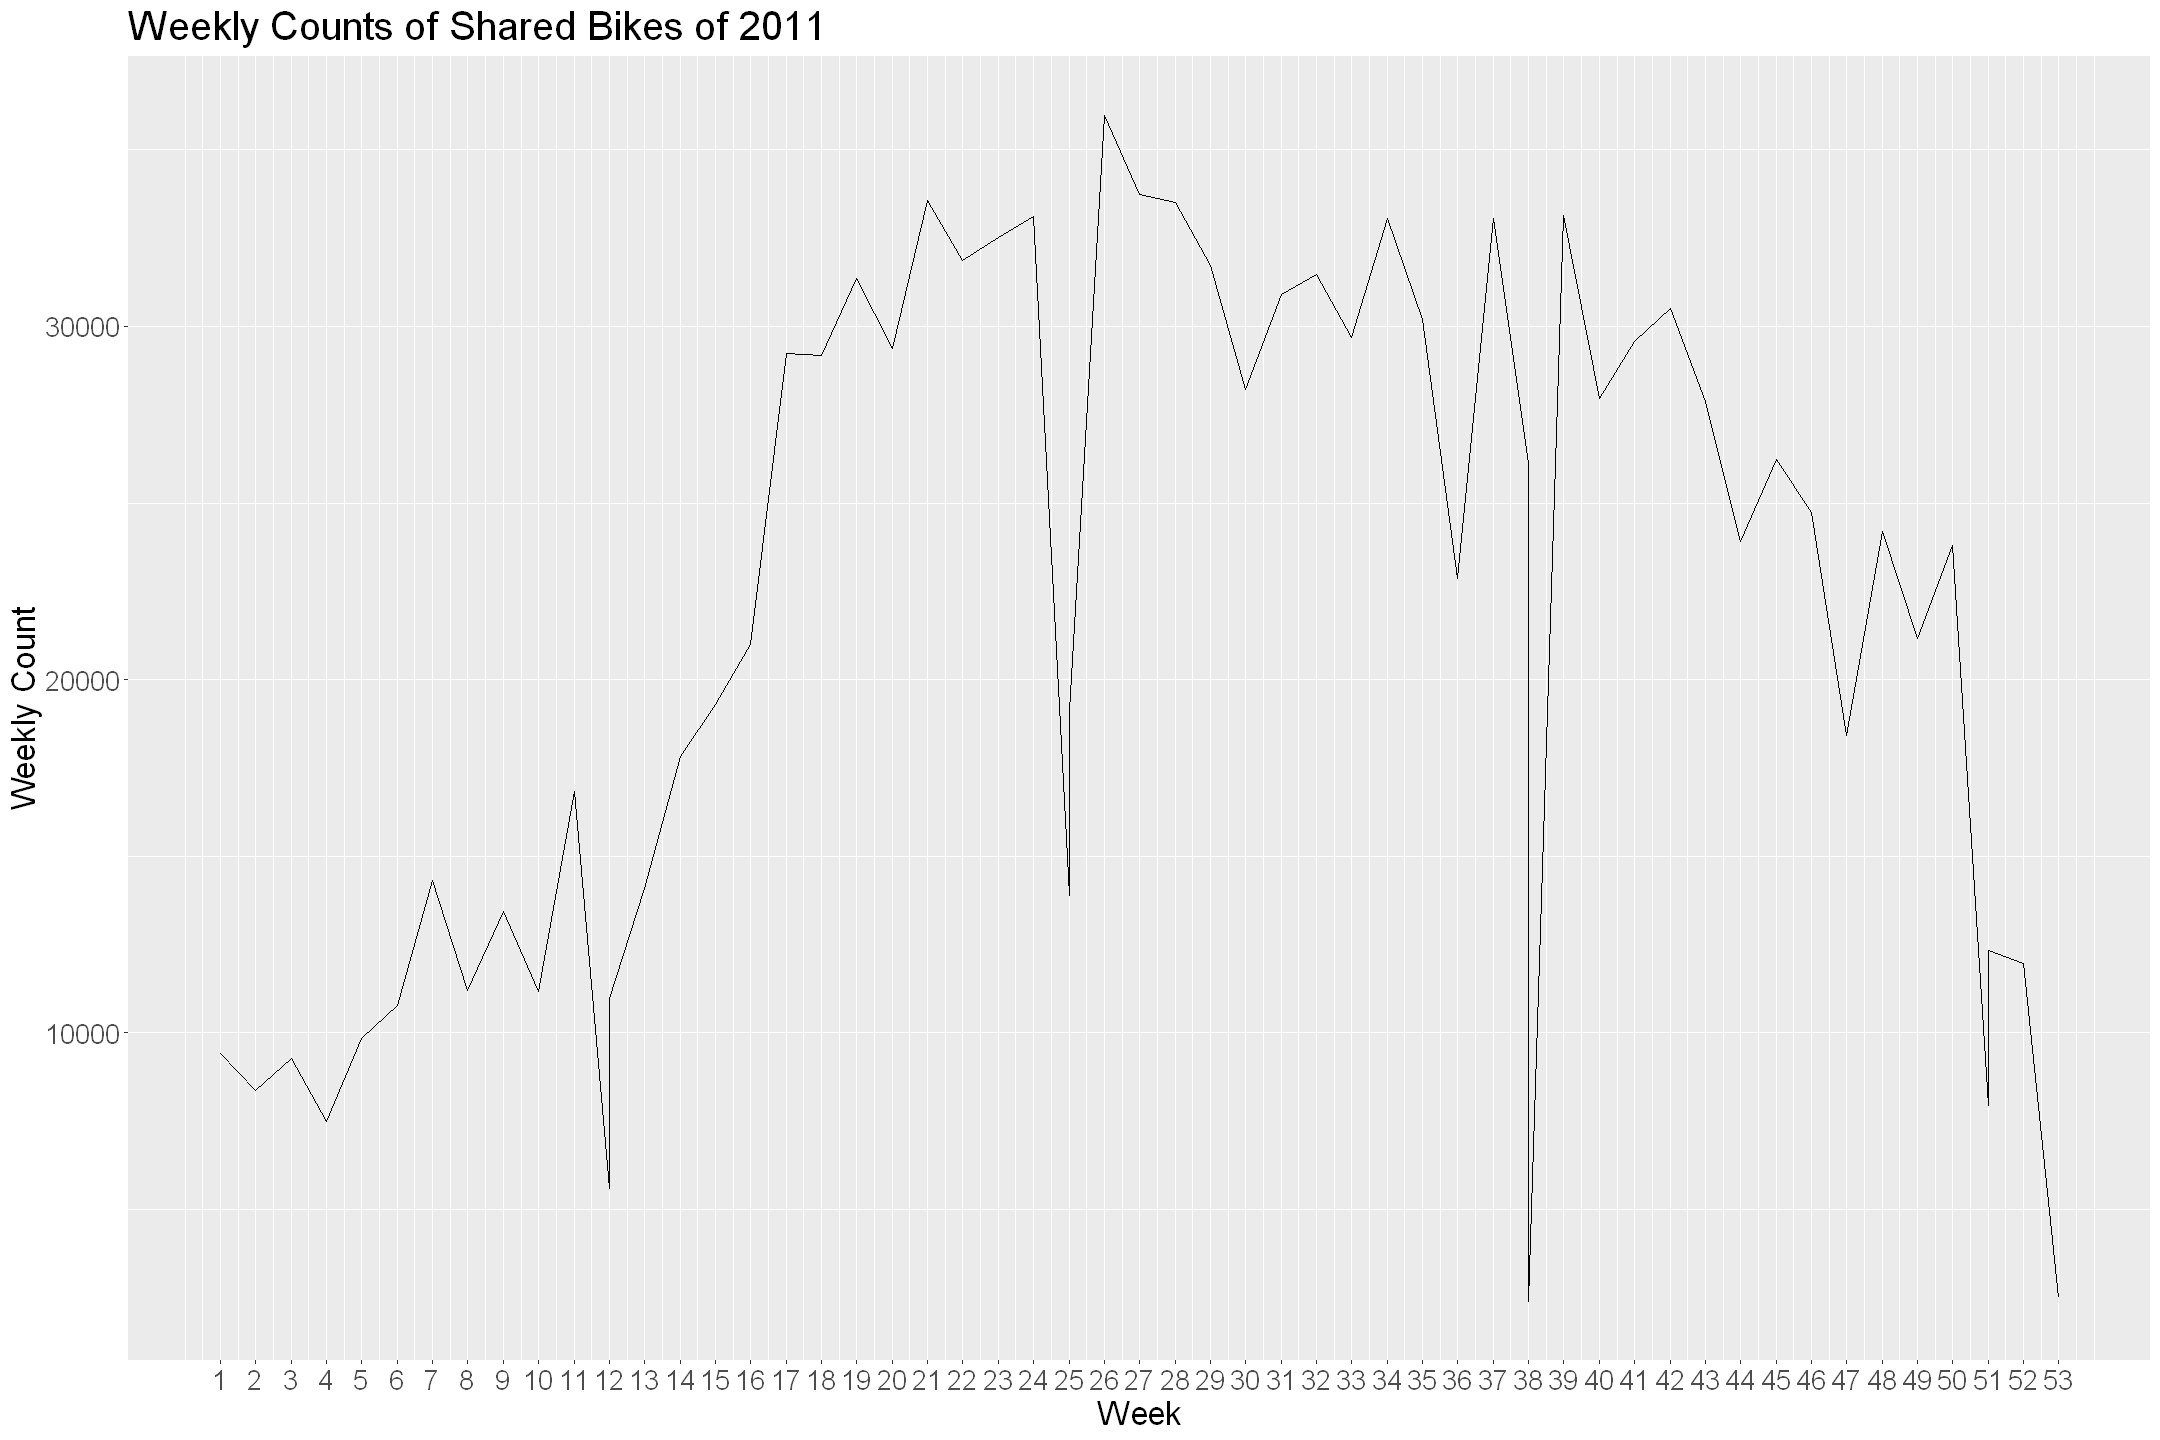

In [106]:
ggplot(filter(weekly, year == 2011), aes(x = week, y = cnt)) +
    geom_line() + 
    scale_x_continuous(breaks = seq(1, 53, by = 1)) +
    #scale_y_continuous(breaks = seq(min(weekly$cnt), 
    #                                max(weekly$cnt), 
    #                                by = 10000)) + 
    labs(title = "Weekly Counts of Shared Bikes of 2011", 
         x = "Week", y = "Weekly Count") + 
    theme(text = element_text(size = 20))